In [16]:
# Import all libraries
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from timm import create_model
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import pandas as pd

In [25]:
# Define emotion labels based on your mapping - Load and Preprocess RAF-DB Dataset
emotion_labels = {0: "Happy", 1: "Surprise", 2: "Sad", 3: "Anger", 4: "Disgust", 5: "Fear", 6: "Neutral"}

class RAFDBDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
        # RAF-DB classes: 1=Surprise, 2=Fear, 3=Disgust, 4=Happy, 5=Sad, 6=Anger, 7=Neutral
        # Desired mapping: Happy=0, Surprise=1, Sad=2, Anger=3, Disgust=4, Fear=5, Neutral=6
        self.label_map = {1: 1, 2: 5, 3: 4, 4: 0, 5: 2, 6: 3, 7: 6}

        # Dynamically load images and labels from folder structure
        self.image_data = []
        for class_folder in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_folder)
            if os.path.isdir(class_path) and class_folder.isdigit():
                label = int(class_folder)  # Get RAF-DB label (1-7) from folder name
                if label in self.label_map:
                    for filename in os.listdir(class_path):
                        if filename.endswith(".jpg") or filename.endswith(".png"):
                            self.image_data.append([filename, label])

        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_name, original_rafdb_label = self.image_data[idx]
        # Map RAF-DB label (1-7) to desired label (0-6)
        mapped_label = self.label_map[original_rafdb_label]
        # Construct image path using the original RAF-DB label (folder name)
        img_path = os.path.join(self.img_dir, str(original_rafdb_label), img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, mapped_label

# Define enhanced transforms for training with additional augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Define minimal transforms for testing
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
base_path = "/kaggle/input/raf-db-dataset"
train_img_dir = os.path.join(base_path, "DATASET/train")
test_img_dir = os.path.join(base_path, "DATASET/test")

if not os.path.exists(train_img_dir):
    print(f"Warning: Training image directory not found at {train_img_dir}")
if not os.path.exists(test_img_dir):
    print(f"Warning: Test image directory not found at {test_img_dir}")

# Load full training dataset with train transforms (for now)
full_train_dataset = RAFDBDataset(img_dir=train_img_dir, transform=train_transforms)

# Split into train and validation (80% train, 20% val)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply test transforms to validation set
val_dataset.dataset.transform = test_transforms  # override transform for validation subset

# Load test dataset
test_dataset = RAFDBDataset(img_dir=test_img_dir, transform=test_transforms)

# Dataset size info
print(f"Total Training Data: {len(full_train_dataset)}")
print(f"Training Split: {len(train_dataset)}")
print(f"Validation Split: {len(val_dataset)}")
print(f"Test Set: {len(test_dataset)}")

# Class distribution (based on original full training data)
train_original_labels = [item[1] for item in full_train_dataset.image_data]
train_class_counts = pd.Series(train_original_labels).value_counts().sort_index()
print("\nTraining set class distribution (Original RAF-DB labels 1-7 mapped to target emotion names):")
for original_label, count in train_class_counts.items():
    mapped_label = full_train_dataset.label_map[original_label]
    emotion_name = emotion_labels[mapped_label]
    print(f"Original Class {original_label} ({emotion_name}): {count} images")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Batch shape check
train_image, train_label = next(iter(train_loader))
print(f"\nTrain batch: Image shape {train_image.shape}, Label shape {train_label.shape}")

val_image, val_label = next(iter(val_loader))
print(f"Validation batch: Image shape {val_image.shape}, Label shape {val_label.shape}")

test_image, test_label = next(iter(test_loader))
print(f"Test batch: Image shape {test_image.shape}, Label shape {test_label.shape}")

Total Training Data: 12271
Training Split: 9816
Validation Split: 2455
Test Set: 3068

Training set class distribution (Original RAF-DB labels 1-7 mapped to target emotion names):
Original Class 1 (Surprise): 1290 images
Original Class 2 (Fear): 281 images
Original Class 3 (Disgust): 717 images
Original Class 4 (Happy): 4772 images
Original Class 5 (Sad): 1982 images
Original Class 6 (Anger): 705 images
Original Class 7 (Neutral): 2524 images

Train batch: Image shape torch.Size([32, 3, 224, 224]), Label shape torch.Size([32])
Validation batch: Image shape torch.Size([32, 3, 224, 224]), Label shape torch.Size([32])
Test batch: Image shape torch.Size([32, 3, 224, 224]), Label shape torch.Size([32])


Number of images processed in this batch: 32
Number of images displayed: 8


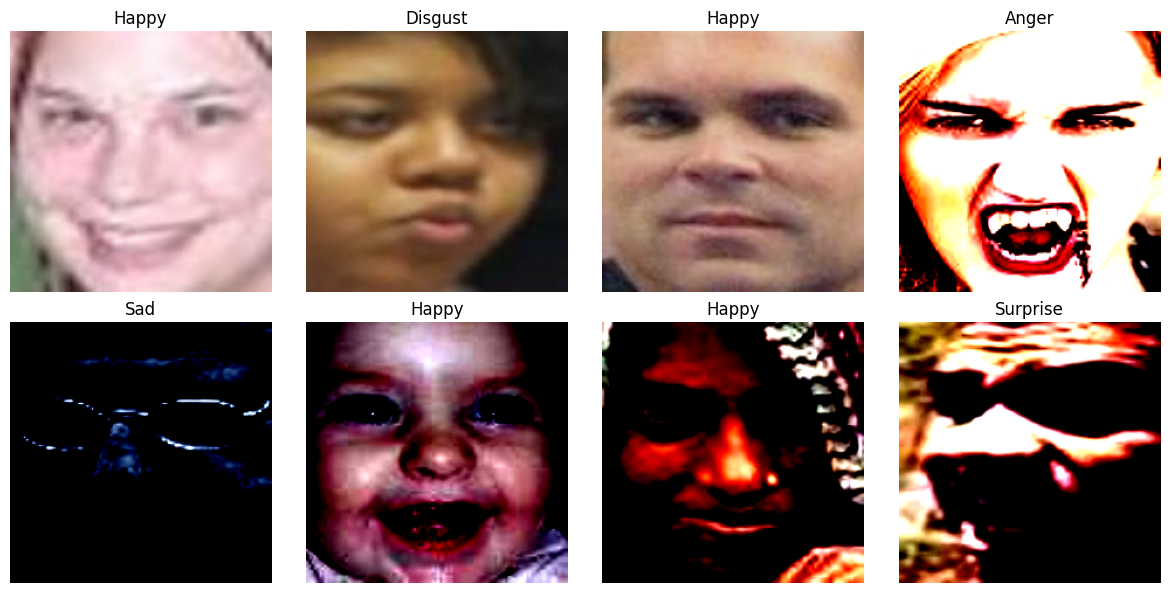

In [26]:
# After augmentation
# Function to denormalize images for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (tensor * std) + mean
    return tensor

# Get a batch of training images
images, labels = next(iter(train_loader))

# Denormalize images for visualization
images = denormalize(images)

# Print the number of images in the batch
print(f"Number of images processed in this batch: {images.shape[0]}")
print(f"Number of images displayed: 8")

# Plot the first 8 images in the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
    axes[i].imshow(img)  # Since images are grayscale with 3 channels, this will show as grayscale
    axes[i].set_title(emotion_labels[labels[i].item()])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [27]:
# MLCA Module (Lightweight)
class MLCA(nn.Module):
    def __init__(self, x1_dim, x2_dim, embed_dim=512, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.x1_proj = nn.Linear(x1_dim, embed_dim)
        self.x2_proj = nn.Linear(x2_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.scale = (embed_dim // num_heads) ** -0.5

    def forward(self, x1, x2):
        x1 = self.x1_proj(x1)  # (B, N, embed_dim)
        x2 = self.x2_proj(x2)
        B, N, C = x1.shape

        q = self.q_proj(x1).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.k_proj(x2).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.v_proj(x2).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        q = q.reshape(B * self.num_heads, N, C // self.num_heads)
        k = k.reshape(B * self.num_heads, N, C // self.num_heads)
        v = v.reshape(B * self.num_heads, N, C // self.num_heads)

        attn = torch.bmm(q, k.transpose(1, 2)) * self.scale
        attn = attn.softmax(dim=-1)
        out = torch.bmm(attn, v)

        out = out.reshape(B, self.num_heads, N, C // self.num_heads).permute(0, 2, 1, 3).reshape(B, N, C)
        out = self.out_proj(out)
        return out

# SwinFace Model (Lightweight) # swin_large_patch4_window7_224 # tiny, base, large
class SwinFace(nn.Module):
    def __init__(self, backbone_name='swin_base_patch4_window7_224', embed_dim=512, num_heads=4, num_classes=7, max_tokens=32):
        super().__init__()
        self.backbone = create_model(backbone_name, pretrained=True, features_only=True)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.max_tokens = max_tokens

        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        f1 = features[-2]  # (B, C1, H1, W1)
        f2 = features[-1]  # (B, C2, H2, W2)

        B, C1, H1, W1 = f1.shape
        B, C2, H2, W2 = f2.shape

        f1_flat = f1.flatten(2).transpose(1, 2)  # (B, H1*W1, C1)
        f2_flat = f2.flatten(2).transpose(1, 2)  # (B, H2*W2, C2)

        N = min(f1_flat.size(1), f2_flat.size(1), self.max_tokens)
        f1_flat = f1_flat[:, :N, :]
        f2_flat = f2_flat[:, :N, :]

        if not hasattr(self, 'mlca'):
            self.mlca = MLCA(
                x1_dim=C1,
                x2_dim=C2,
                embed_dim=self.embed_dim,
                num_heads=self.num_heads
            ).to(x.device)

        fused = self.mlca(f1_flat, f2_flat)
        pooled = fused.mean(dim=1)
        logits = self.classifier(pooled)
        return logits

# Device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinFace().to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} Total Parameters.")

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = torch.amp.GradScaler()

# Checkpoint logic
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

start_epoch = 0
best_acc = 0.0
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_swinface_model.pth")

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Load checkpoint if available
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    best_acc = checkpoint.get('best_acc', 0.0)
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accs = checkpoint.get('train_accs', [])
    val_accs = checkpoint.get('val_accs', [])
    print(f"Resumed training from epoch {start_epoch} with best accuracy {best_acc:.2f}%")


86,745,791 Total Parameters.


In [28]:
# Training Model
patience = 15
epochs_no_improve = 0
early_stop = False
epochs = 30

best_model_path = "/kaggle/working/best_swinface_model.pth"
last_checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_swinface_model.pth")

for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_preds, train_truths = [], []

    train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} [Training]")
    for batch_idx, (imgs, labels) in train_progress:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if torch.isnan(loss):
            print(f"NaN loss at epoch {epoch+1}, batch {batch_idx+1}. Skipping.")
            continue

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        train_preds.extend(preds.detach().cpu().numpy())
        train_truths.extend(labels.detach().cpu().numpy())

        train_progress.set_postfix({'loss': running_loss / (batch_idx + 1)})

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds, val_truths = [], []

    val_progress = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
    with torch.no_grad():
        for batch_idx, (imgs, labels) in val_progress:
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            val_preds.extend(preds.detach().cpu().numpy())
            val_truths.extend(labels.detach().cpu().numpy())
            val_progress.set_postfix({'loss': val_running_loss / (batch_idx + 1)})

    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

        # --- Print epoch summary ---
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    torch.save(checkpoint, last_checkpoint_path)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with Val Acc: {best_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No improvement in Val Acc for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            early_stop = True
            break

    scheduler.step()

Epoch 1/30 [Training]: 100%|██████████| 307/307 [03:06<00:00,  1.65it/s, loss=1.46]


Epoch [1/30] | Train Loss: 1.4560, Train Acc: 47.23% | Val Loss: 1.0947, Val Acc: 61.25%
New best model saved with Val Acc: 61.25%


Epoch 2/30 [Training]: 100%|██████████| 307/307 [02:43<00:00,  1.87it/s, loss=1.02]


Epoch [2/30] | Train Loss: 1.0210, Train Acc: 65.66% | Val Loss: 0.7964, Val Acc: 73.83%
New best model saved with Val Acc: 73.83%


Epoch 3/30 [Training]:  65%|██████▍   | 199/307 [01:48<00:59,  1.83it/s, loss=0.781]


KeyboardInterrupt: 

In [ ]:
# Save Model
torch.save(model.state_dict(), '/kaggle/working/swinface_model.pth')
print("Saved final model state to /kaggle/working/swinface_model.pth")

In [ ]:
# Evaluate model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load Best Model
best_model_path = "/kaggle/working/best_swinface_model.pth"
last_checkpoint_path = "/kaggle/working/checkpoints/checkpoint_swinface_model.pth"

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Loaded best model for evaluation.")
elif os.path.exists(last_checkpoint_path):
    checkpoint = torch.load(last_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded last checkpoint model (best model not found).")
else:
    print("No model found.")
    test_acc = 0.0

# Inference Loop
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Basic Accuracy
test_acc = 100 * correct / total if total > 0 else 0.0
print(f"\nTest Accuracy: {test_acc:.2f}%")

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)
y_true_bin = label_binarize(y_true, classes=range(7))  # 7 classes

# Metrics
precision = precision_score(y_true, y_pred, average='macro') * 100
recall = recall_score(y_true, y_pred, average='macro') * 100
f1 = f1_score(y_true, y_pred, average='macro') * 100
roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')

print(f"\nPrecision (macro): {precision:.2f}%")
print(f"Recall (macro): {recall:.2f}%")
print(f"F1-score (macro): {f1:.2f}%")
print(f"ROC-AUC (macro): {roc_auc:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve (One-vs-Rest)
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves per Class (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Step: Visualize plot training curve
if train_losses and val_losses and train_accs and val_accs:
    plt.figure(figsize=(14, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='blue', linewidth=2)
    plt.plot(val_losses, label="Validation Loss", color='orange', linewidth=2)
    plt.title("Loss over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy", color='green', linewidth=2)
    plt.plot(val_accs, label="Validation Accuracy", color='red', linewidth=2)
    plt.title("Accuracy over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("/kaggle/working/training_curves.png")
    plt.show()
    print("Saved training curves to `/kaggle/working/training_curves.png`")
else:
    print("Training curves not plotted. Lists are empty (training may not have completed).")